=== Liposome Hole Analysis Started ===
Found 6664 lipid headgroups
Lipid types: {'CHOL', 'DPPC'}
Liposome center: [271.33398 269.05624 287.22824]
Radius stats: avg=102.94Å, max=135.10Å, min=66.16Å, std=18.05Å
Hole detection - Method: std, Threshold: 100.8414
Detected 347 hole bins
Found 7 holes, keeping the largest one with 323 bins

Found 115 unique lipid residues near the hole (distance threshold: 20.0Å)
Figure saved to: largest_hole_analysis.png


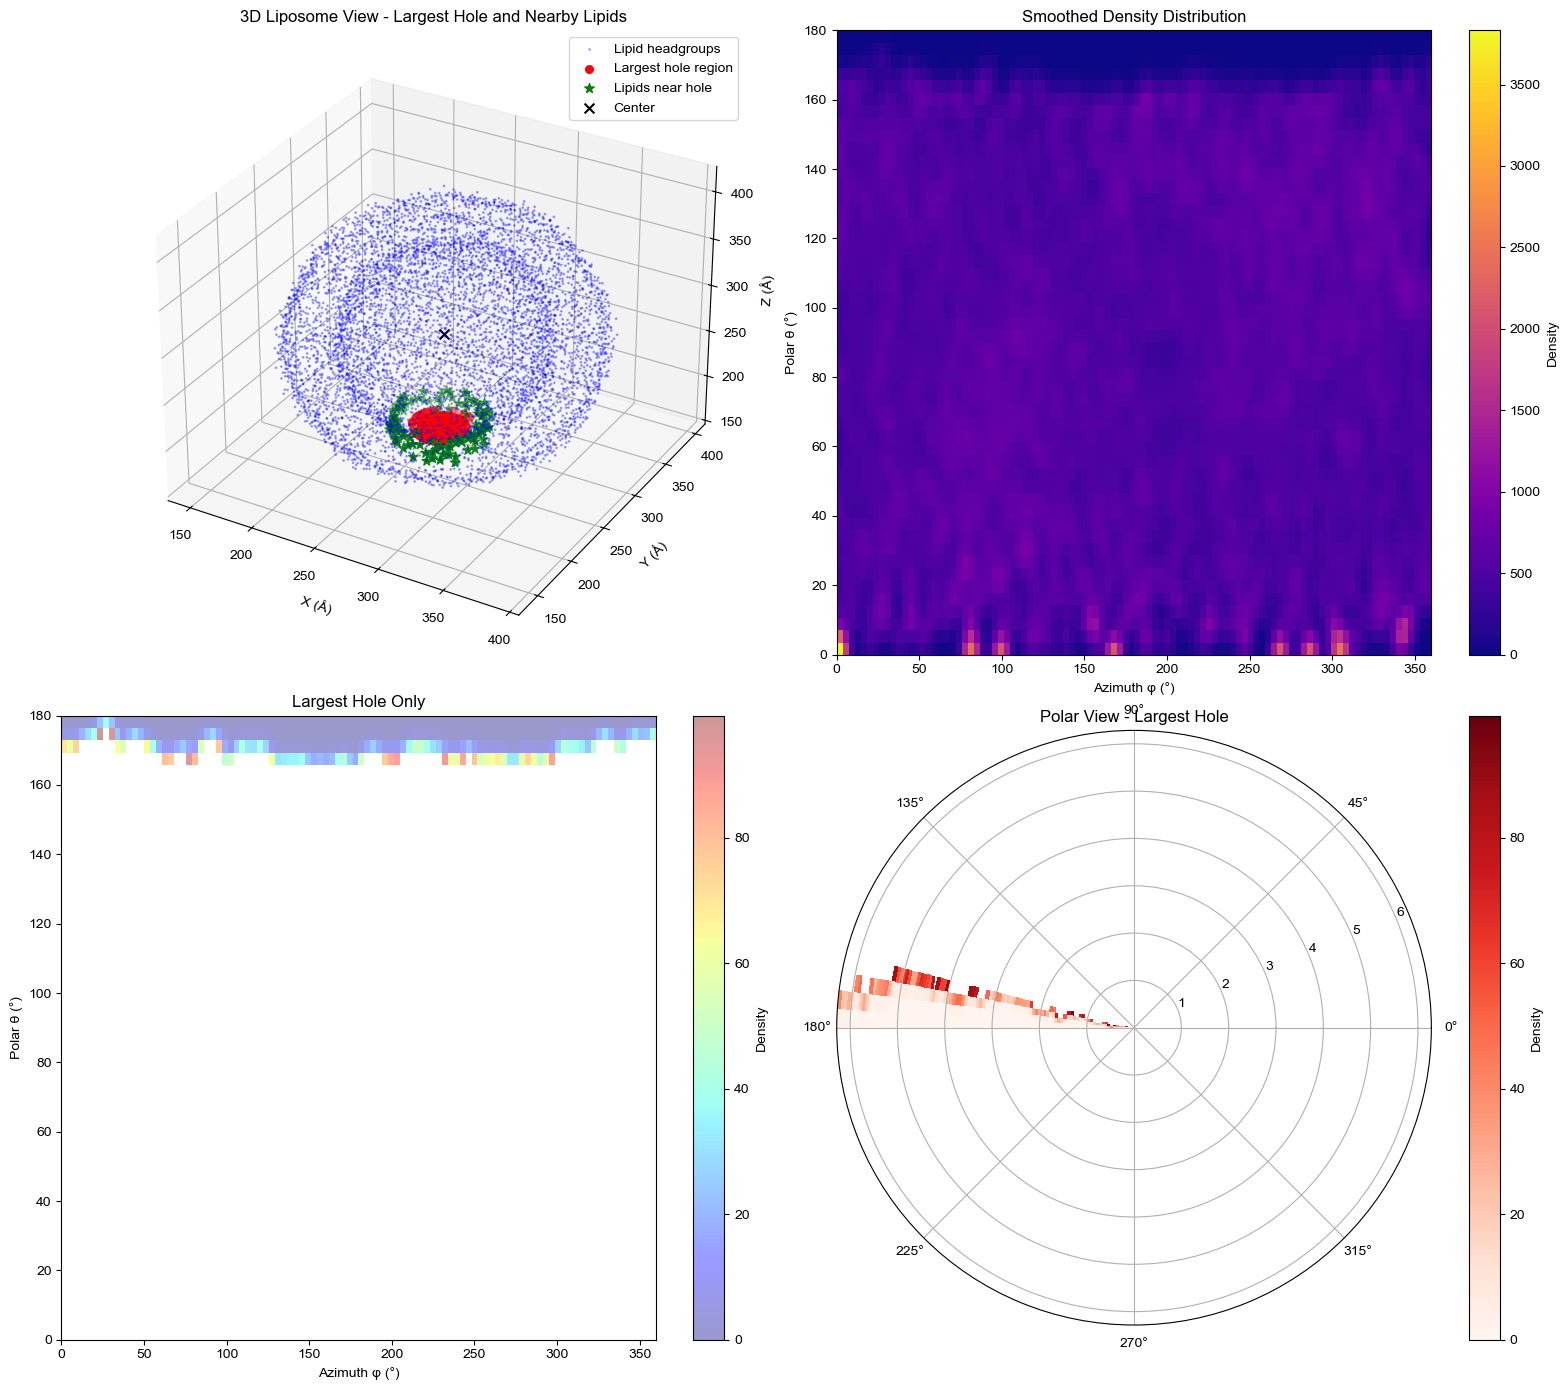


Liposome Hole Analysis Results - Largest Hole Only
Liposome size: 6664 lipids
Average radius: 102.94 Å
Grid resolution: 50 × 100

Largest Hole Analysis:
Hole area: 1443.58 Å²
Number of grid bins in hole: 323
Hole coverage: 1.08% of surface area
Total surface area: 133154.36 Å²
Approximate hole diameter: 42.87 Å

Lipids near the hole region:
----------------------------------------
ResID:   75 | Name: CHOL   | Distance:  14.28 Å
ResID:  162 | Name: CHOL   | Distance:  17.56 Å
ResID:  826 | Name: CHOL   | Distance:  16.30 Å
ResID: 1224 | Name: CHOL   | Distance:  15.58 Å
ResID: 1487 | Name: CHOL   | Distance:  19.04 Å
ResID: 1609 | Name: CHOL   | Distance:  17.30 Å
ResID: 1868 | Name: CHOL   | Distance:  11.65 Å
ResID: 1909 | Name: CHOL   | Distance:  18.80 Å
ResID: 1954 | Name: CHOL   | Distance:  13.51 Å
ResID: 2251 | Name: CHOL   | Distance:   9.20 Å
ResID: 2325 | Name: CHOL   | Distance:  12.89 Å
ResID: 2372 | Name: CHOL   | Distance:  19.90 Å
ResID: 2483 | Name: CHOL   | Distance: 

In [134]:
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as mda
from scipy.spatial import KDTree
from scipy.ndimage import gaussian_filter
from collections import deque
import warnings
warnings.filterwarnings('ignore')

def extract_headgroups(gro_file, lipid_selection="name P"):
    """Extract lipid headgroup coordinates and residue data"""
    u = mda.Universe(gro_file)
    headgroup_atoms = u.select_atoms(lipid_selection)
    coordinates = headgroup_atoms.positions
    n_lipids = len(headgroup_atoms)
    lipid_names = headgroup_atoms.names
    residue_ids = headgroup_atoms.resids
    residue_names = headgroup_atoms.resnames

    print(f"Found {n_lipids} lipid headgroups")
    print(f"Lipid types: {set(residue_names)}")

    return coordinates, n_lipids, lipid_names, residue_ids, residue_names, headgroup_atoms

def calculate_geometry(coordinates):
    """Calculate liposome geometry"""
    center = np.mean(coordinates, axis=0)
    distances = np.linalg.norm(coordinates - center, axis=1)

    avg_radius = np.mean(distances)
    max_radius = np.max(distances)
    min_radius = np.min(distances)
    std_radius = np.std(distances)

    print(f"Liposome center: {center}")
    print(f"Radius stats: avg={avg_radius:.2f}Å, max={max_radius:.2f}Å, "
          f"min={min_radius:.2f}Å, std={std_radius:.2f}Å")

    return center, avg_radius, max_radius, min_radius, std_radius

def create_spherical_grid(n_theta=50, n_phi=100):
    """Create spherical grid"""
    theta_bins = np.linspace(0, np.pi, n_theta + 1)
    phi_bins = np.linspace(0, 2 * np.pi, n_phi + 1)

    theta_centers = (theta_bins[:-1] + theta_bins[1:]) / 2
    phi_centers = (phi_bins[:-1] + phi_bins[1:]) / 2

    d_theta = np.pi / n_theta
    d_phi = 2 * np.pi / n_phi
    bin_areas = np.sin(theta_centers) * d_theta * d_phi

    return theta_bins, phi_bins, theta_centers, phi_centers, bin_areas, n_theta, n_phi

def assign_points_to_bins(coordinates, center, theta_bins, phi_bins, theta_centers, bin_areas, n_theta, n_phi):
    """Assign points to spherical grid bins"""
    relative_coords = coordinates - center
    r = np.linalg.norm(relative_coords, axis=1)

    x, y, z = relative_coords[:, 0], relative_coords[:, 1], relative_coords[:, 2]
    theta = np.arccos(z / r)
    phi = np.arctan2(y, x)
    phi = np.where(phi < 0, phi + 2*np.pi, phi)

    theta_indices = np.digitize(theta, theta_bins) - 1
    phi_indices = np.digitize(phi, phi_bins) - 1

    theta_indices = np.clip(theta_indices, 0, n_theta - 1)
    phi_indices = np.clip(phi_indices, 0, n_phi - 1)

    density_matrix = np.zeros((n_theta, n_phi))

    for i, (t_idx, p_idx) in enumerate(zip(theta_indices, phi_indices)):
        density_matrix[t_idx, p_idx] += 1

    density_per_sr = np.zeros_like(density_matrix)
    for i in range(n_theta):
        if bin_areas[i] > 0:
            density_per_sr[i, :] = density_matrix[i, :] / bin_areas[i]

    return density_matrix, density_per_sr, theta_indices, phi_indices, theta, phi

def smooth_density(density_per_sr, sigma=0.1):
    """Smooth density distribution"""
    smoothed_density = gaussian_filter(density_per_sr, sigma=sigma)
    return smoothed_density

def detect_holes(density_matrix, method='percentile', threshold_value=10):
    """Detect hole regions"""
    flat_density = density_matrix.flatten()

    if method == 'percentile':
        threshold = np.percentile(flat_density[flat_density > 0], threshold_value)
    elif method == 'std':
        mean_density = np.mean(flat_density[flat_density > 0])
        std_density = np.std(flat_density[flat_density > 0])
        threshold = mean_density - threshold_value * std_density
    elif method == 'absolute':
        threshold = threshold_value
    else:
        raise ValueError("Method must be 'percentile', 'std', or 'absolute'")

    holes_mask = density_matrix < threshold
    n_hole_bins = np.sum(holes_mask)

    print(f"Hole detection - Method: {method}, Threshold: {threshold:.4f}")
    print(f"Detected {n_hole_bins} hole bins")

    return holes_mask, threshold

def find_contiguous_holes(holes_mask, n_theta, n_phi):
    """Find contiguous hole regions and keep only the largest one"""
    visited = np.zeros_like(holes_mask, dtype=bool)
    holes = []

    def bfs(start_i, start_j):
        """Breadth-first search for contiguous regions"""
        queue = deque([(start_i, start_j)])
        current_hole = []

        while queue:
            i, j = queue.popleft()
            if visited[i, j]:
                continue

            visited[i, j] = True
            current_hole.append((i, j))

            # Check 4-neighborhood
            for di, dj in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                ni, nj = i + di, j + dj
                if (0 <= ni < n_theta and 0 <= nj < n_phi and
                    holes_mask[ni, nj] and not visited[ni, nj]):
                    queue.append((ni, nj))

        return current_hole

    for i in range(n_theta):
        for j in range(n_phi):
            if holes_mask[i, j] and not visited[i, j]:
                hole = bfs(i, j)
                if len(hole) > 1:  # Only consider holes with multiple bins
                    holes.append(hole)

    # Find the largest hole
    if holes:
        largest_hole = max(holes, key=len)
        print(f"Found {len(holes)} holes, keeping the largest one with {len(largest_hole)} bins")

        # Create mask with only the largest hole
        largest_hole_mask = np.zeros_like(holes_mask, dtype=bool)
        for i, j in largest_hole:
            largest_hole_mask[i, j] = True

        contiguous_holes = [largest_hole]  # Keep only the largest hole
        holes_mask = largest_hole_mask  # Update holes mask to only include largest hole
    else:
        contiguous_holes = []
        print("No holes found")

    return contiguous_holes, holes_mask

def calculate_hole_statistics(contiguous_holes, bin_areas, avg_radius):
    """Calculate hole statistics for the largest hole only"""
    holes = contiguous_holes
    hole_areas = []

    for hole in holes:
        hole_area = 0.0  # 确保是标量
        for i, j in hole:
            # 确保 bin_areas[i] 是标量
            area_contribution = float(bin_areas[i]) * (float(avg_radius)**2)
            hole_area += area_contribution

        hole_areas.append(float(hole_area))  # 确保添加的是标量

    # 其余代码保持不变...

    if hole_areas:
        total_hole_area = np.sum(hole_areas)
        avg_hole_area = np.mean(hole_areas)
        max_hole_area = np.max(hole_areas)
        n_holes = len(holes)
    else:
        total_hole_area = avg_hole_area = max_hole_area = 0
        n_holes = 0

    sphere_area = 4 * np.pi * avg_radius**2
    hole_coverage = total_hole_area / sphere_area * 100

    hole_stats = {
        'n_holes': n_holes,
        'hole_areas': hole_areas,
        'avg_hole_area': avg_hole_area,
        'max_hole_area': max_hole_area,
        'total_hole_area': total_hole_area,
        'hole_coverage': hole_coverage,
        'sphere_area': sphere_area
    }

    return hole_stats

def find_lipids_near_hole(coordinates, residue_ids, residue_names, center, avg_radius,
                         hole_bins, theta_centers, phi_centers, distance_threshold=10.0):
    """
    Find lipids near the hole region

    Parameters:
    coordinates: all lipid coordinates
    residue_ids: residue IDs for each lipid
    residue_names: residue names for each lipid
    center: liposome center
    avg_radius: average liposome radius
    hole_bins: list of (theta_idx, phi_idx) for hole bins
    theta_centers: theta center values
    phi_centers: phi center values
    distance_threshold: distance threshold for considering lipids as "near" the hole (Å)
    """
    if not hole_bins:
        return [], []

    # Create representative points for the hole region
    hole_points = []
    for theta_idx, phi_idx in hole_bins:
        theta = theta_centers[theta_idx]
        phi = phi_centers[phi_idx]

        # Convert spherical coordinates to Cartesian
        x = center[0] + avg_radius * np.sin(theta) * np.cos(phi)
        y = center[1] + avg_radius * np.sin(theta) * np.sin(phi)
        z = center[2] + avg_radius * np.cos(theta)
        hole_points.append([x, y, z])

    hole_points = np.array(hole_points)

    # Create KDTree for efficient distance calculation
    hole_tree = KDTree(hole_points)

    # Find lipids near any hole point
    nearby_indices = []
    nearby_residues = []

    for i, lipid_coord in enumerate(coordinates):
        # Calculate distance to nearest hole point
        dist, _ = hole_tree.query(lipid_coord.reshape(1, -1))
        if dist[0] <= distance_threshold:
            nearby_indices.append(i)
            nearby_residues.append({
                'residue_id': residue_ids[i],
                'residue_name': residue_names[i],
                'distance_to_hole': dist[0],
                'coordinates': lipid_coord
            })

    # Remove duplicates (same residue ID)
    unique_residues = {}
    for residue in nearby_residues:
        resid = residue['residue_id']
        if resid not in unique_residues or residue['distance_to_hole'] < unique_residues[resid]['distance_to_hole']:
            unique_residues[resid] = residue

    # Sort by residue ID
    sorted_residues = sorted(unique_residues.values(), key=lambda x: x['residue_id'])

    print(f"\nFound {len(sorted_residues)} unique lipid residues near the hole (distance threshold: {distance_threshold}Å)")

    return sorted_residues, nearby_indices

def visualize_results(results, theta_centers, phi_centers, avg_radius, nearby_residues=None, save_path=None):
    """Visualize analysis results - showing only the largest hole"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))

    # 1. 3D liposome view with largest hole and nearby lipids
    ax = axes[0, 0]
    ax.remove()
    ax = fig.add_subplot(2, 2, 1, projection='3d')

    coords = results['coordinates']
    center = results['center']

    # Plot all lipid headgroups
    ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2],
              c='blue', alpha=0.3, s=1, label='Lipid headgroups')

    # Plot the largest hole region
    if results['contiguous_holes']:
        largest_hole = results['contiguous_holes'][0]
        hole_coords = []

        for i, j in largest_hole:
            theta = theta_centers[i]
            phi = phi_centers[j]
            x = center[0] + avg_radius * np.sin(theta) * np.cos(phi)
            y = center[1] + avg_radius * np.sin(theta) * np.sin(phi)
            z = center[2] + avg_radius * np.cos(theta)
            hole_coords.append([x, y, z])

        if hole_coords:
            hole_coords = np.array(hole_coords)
            ax.scatter(hole_coords[:, 0], hole_coords[:, 1], hole_coords[:, 2],
                      c='red', s=30, label='Largest hole region')

    # Plot nearby lipids if available
    if nearby_residues:
        nearby_coords = np.array([res['coordinates'] for res in nearby_residues])
        ax.scatter(nearby_coords[:, 0], nearby_coords[:, 1], nearby_coords[:, 2],
                  c='green', s=50, marker='*', label='Lipids near hole')

    ax.scatter(*center, c='black', s=50, marker='x', label='Center')
    ax.set_xlabel('X (Å)')
    ax.set_ylabel('Y (Å)')
    ax.set_zlabel('Z (Å)')
    ax.set_title('3D Liposome View - Largest Hole and Nearby Lipids')
    ax.legend()

    # 2. Smoothed density distribution
    im1 = axes[0, 1].imshow(results['smoothed_density'],
                           extent=[0, 360, 0, 180], aspect='auto',
                           cmap='plasma', origin='lower')
    axes[0, 1].set_xlabel('Azimuth φ (°)')
    axes[0, 1].set_ylabel('Polar θ (°)')
    axes[0, 1].set_title('Smoothed Density Distribution')
    plt.colorbar(im1, ax=axes[0, 1], label='Density')

    # 3. Largest hole only
    hole_density = results['smoothed_density'].copy()
    hole_density[~results['holes_mask']] = np.nan

    im2 = axes[1, 0].imshow(hole_density,
                           extent=[0, 360, 0, 180], aspect='auto',
                           cmap='jet',alpha=0.4, origin='lower')
    axes[1, 0].set_xlabel('Azimuth φ (°)')
    axes[1, 0].set_ylabel('Polar θ (°)')
    axes[1, 0].set_title('Largest Hole Only')
    plt.colorbar(im2, ax=axes[1, 0], label='Density')

    # 4. Polar view of largest hole
    ax_polar = axes[1, 1]
    ax_polar.remove()
    ax_polar = fig.add_subplot(2, 2, 4, projection='polar')

    # Create polar density plot highlighting only the largest hole
    theta_grid, phi_grid = np.meshgrid(phi_centers, theta_centers)
    density_polar = results['smoothed_density'].copy()
    density_polar[~results['holes_mask']] = np.nan

    im3 = ax_polar.pcolormesh(phi_grid, theta_grid, density_polar, cmap='Reds', shading='auto')
    ax_polar.set_title('Polar View - Largest Hole')
    plt.colorbar(im3, ax=ax_polar, label='Density')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved to: {save_path}")

    plt.show()

def print_results(results, n_theta, n_phi, nearby_residues=None):
    """Print analysis results for the largest hole only"""
    stats = results['hole_stats']

    print("\n" + "="*60)
    print("Liposome Hole Analysis Results - Largest Hole Only")
    print("="*60)
    print(f"Liposome size: {results['n_lipids']} lipids")
    print(f"Average radius: {results['radii']['avg']:.2f} Å")
    print(f"Grid resolution: {n_theta} × {n_phi}")

    print(f"\nLargest Hole Analysis:")
    if stats['n_holes'] > 0:
        print(f"Hole area: {stats['max_hole_area']:.2f} Å²")
        print(f"Number of grid bins in hole: {len(results['contiguous_holes'][0])}")
        print(f"Hole coverage: {stats['hole_coverage']:.2f}% of surface area")
        print(f"Total surface area: {stats['sphere_area']:.2f} Å²")

        # Calculate approximate hole diameter (assuming circular hole)
        hole_radius = np.sqrt(stats['max_hole_area'] / np.pi)
        print(f"Approximate hole diameter: {2 * hole_radius:.2f} Å")
    else:
        print("No holes detected")

    # Print nearby lipid information
    if nearby_residues:
        print(f"\nLipids near the hole region:")
        print("-" * 40)
        for residue in nearby_residues[:20]:  # Show first 20 residues
            print(f"ResID: {residue['residue_id']:4d} | "
                  f"Name: {residue['residue_name']:6s} | "
                  f"Distance: {residue['distance_to_hole']:6.2f} Å")

        if len(nearby_residues) > 20:
            print(f"... and {len(nearby_residues) - 20} more residues")

    print(f"\nNote: Only the largest hole is shown. Other smaller holes are ignored.")

def analyze_liposome_holes(gro_file, lipid_selection="name PO4 ROH", n_theta=50, n_phi=100,
                          hole_distance_threshold=10.0):
    """Perform complete liposome hole analysis - function version"""
    print("=== Liposome Hole Analysis Started ===")

    # 1. Extract headgroups (now with residue information)
    coordinates, n_lipids, lipid_names, residue_ids, residue_names, headgroup_atoms = extract_headgroups(
        gro_file, lipid_selection)

    # 2. Calculate geometry
    center, avg_radius, max_radius, min_radius, std_radius = calculate_geometry(coordinates)

    # 3. Create spherical grid
    theta_bins, phi_bins, theta_centers, phi_centers, bin_areas, n_theta, n_phi = create_spherical_grid(n_theta, n_phi)

    # 4. Assign points to bins and calculate density
    density_matrix, density_per_sr, theta_idx, phi_idx, theta, phi = assign_points_to_bins(
        coordinates, center, theta_bins, phi_bins, theta_centers, bin_areas, n_theta, n_phi)

    # 5. Smooth density
    smoothed_density = smooth_density(density_per_sr, sigma=1.0)

    # 6. Detect holes
    holes_mask, threshold = detect_holes(smoothed_density, method='std', threshold_value=2)

    # 7. Find contiguous holes and keep only the largest one
    contiguous_holes, holes_mask = find_contiguous_holes(holes_mask, n_theta, n_phi)

    # 8. Calculate statistics
    hole_stats = calculate_hole_statistics(contiguous_holes, bin_areas, avg_radius)

    # 9. Find lipids near the hole
    nearby_residues = []
    if contiguous_holes:
        nearby_residues, nearby_indices = find_lipids_near_hole(
            coordinates, residue_ids, residue_names, center, avg_radius,
            contiguous_holes[0], theta_centers, phi_centers, hole_distance_threshold)
    else:
        print("No hole found, skipping nearby lipid analysis")

    # Compile results
    results = {
        'coordinates': coordinates,
        'center': center,
        'radii': {'avg': avg_radius, 'max': max_radius, 'min': min_radius, 'std': std_radius},
        'density_matrix': density_matrix,
        'smoothed_density': smoothed_density,
        'holes_mask': holes_mask,
        'contiguous_holes': contiguous_holes,
        'hole_stats': hole_stats,
        'n_lipids': n_lipids,
        'nearby_residues': nearby_residues,
        'residue_ids': residue_ids,
        'residue_names': residue_names
    }

    return results, theta_centers, phi_centers, avg_radius, n_theta, n_phi, nearby_residues

def analyze_largest_hole_only(gro_file, lipid_selection="name PO4 ROH", hole_distance_threshold=10.0):
    """Analyze only the largest hole in the liposome - main function"""
    results, theta_centers, phi_centers, avg_radius, n_theta, n_phi, nearby_residues = analyze_liposome_holes(
        gro_file, lipid_selection, hole_distance_threshold=hole_distance_threshold)

    visualize_results(results, theta_centers, phi_centers, avg_radius, nearby_residues,
                     save_path="largest_hole_analysis.png")
    print_results(results, n_theta, n_phi, nearby_residues)

    return results, nearby_residues


if __name__ == "__main__":
    gro_file_path = "300ns.gro"  # Replace with actual file path

    results, nearby_residues = analyze_largest_hole_only(gro_file_path, hole_distance_threshold=20.0)


    print("\nAnalysis completed! Only the largest hole is shown.")
    print(f"Found {len(nearby_residues)} lipid residues near the hole.")


=== Density Distribution Analysis ===
Found 6664 lipid headgroups
Lipid types: {'CHOL', 'DPPC'}
Liposome center: [271.33398 269.05624 287.22824]
Radius stats: avg=102.94Å, max=135.10Å, min=66.16Å, std=18.05Å

Density Distribution Statistics:
Mean density: 497.5678
Standard deviation: 198.3632
Median density: 518.1753
Coefficient of variation: 39.87%


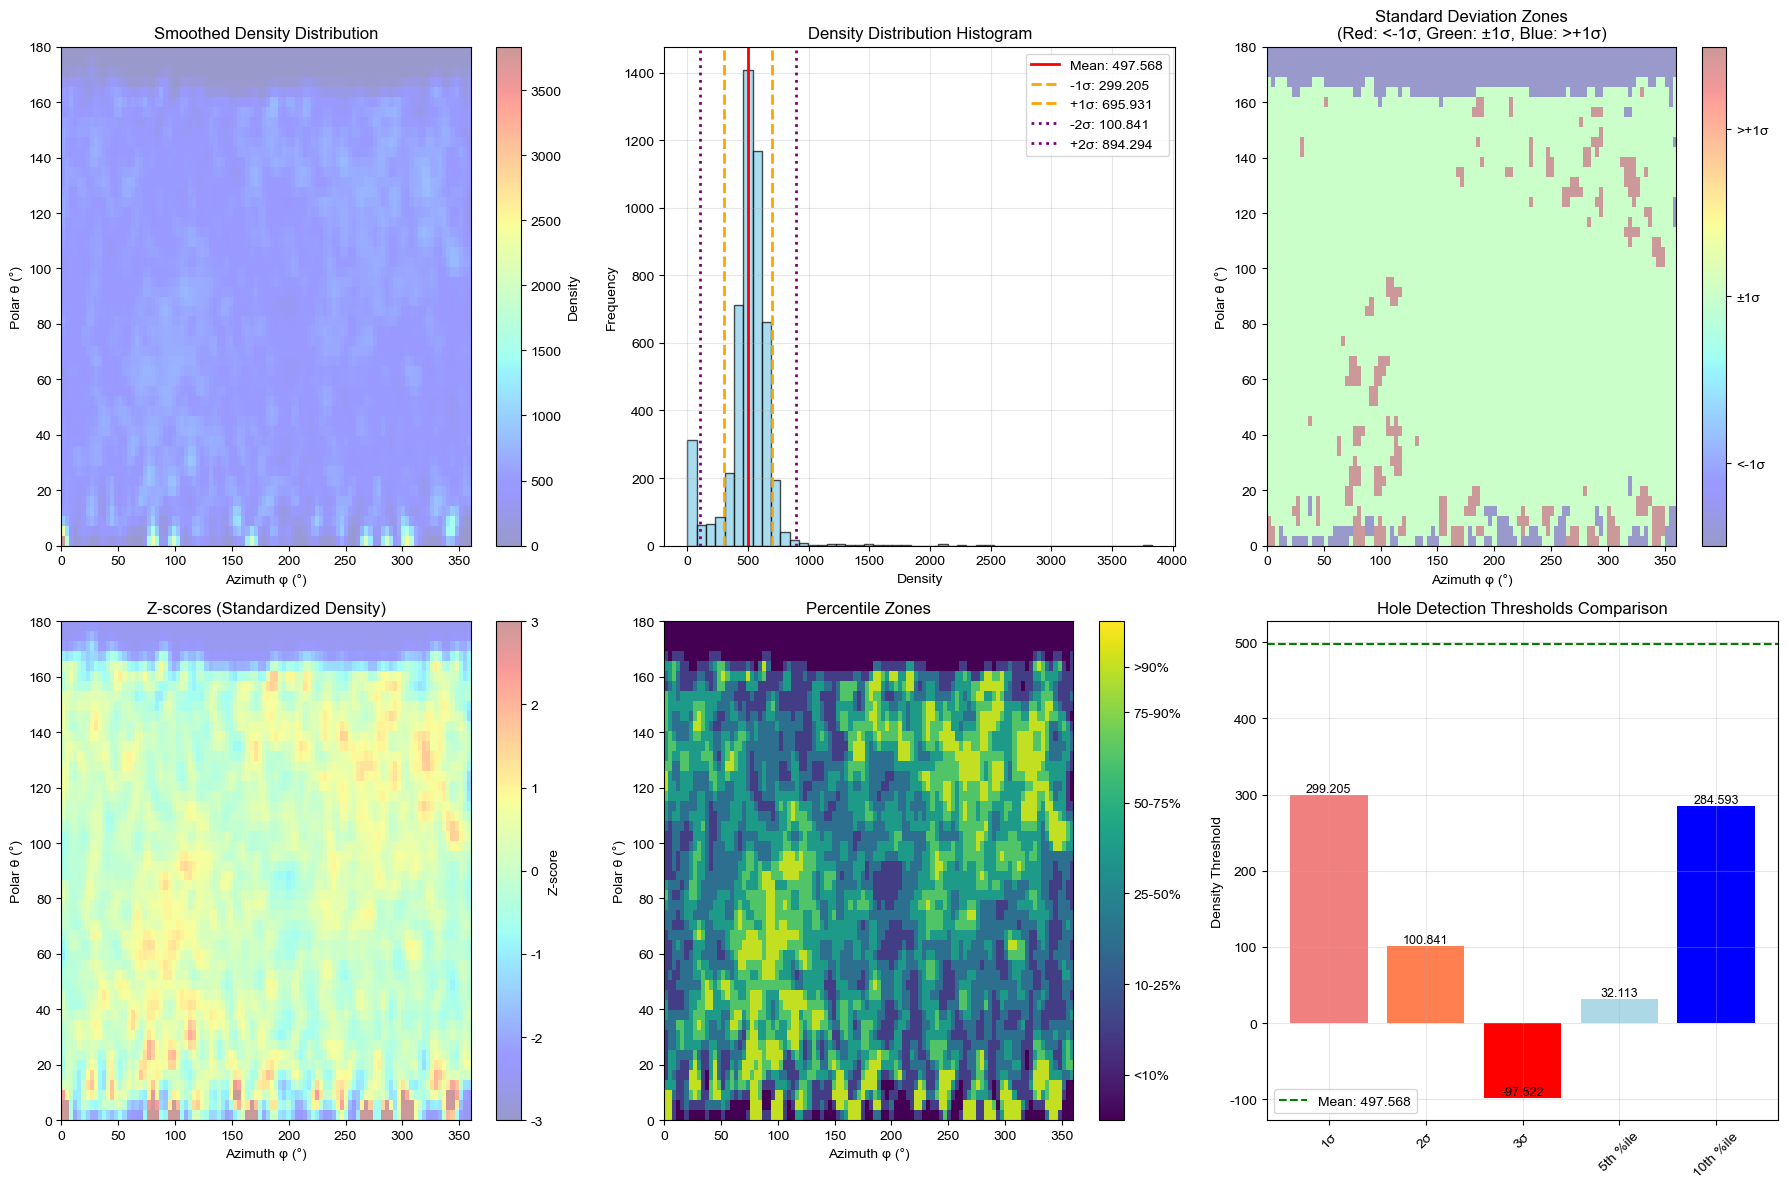


Detailed Percentile Information:
5th percentile: 284.5927
25th percentile: 444.7428
50th percentile (median): 518.1753
75th percentile: 589.9810
90th percentile: 660.7885

Area covered by different standard deviation zones:
< -1σ: 532 bins (10.7%)
±1σ: 4202 bins (84.3%)
> +1σ: 266 bins (5.3%)


In [128]:
def visualize_density_distribution(results, theta_centers, phi_centers, save_path=None):
    """Visualize density distribution with standard deviation analysis"""

    # Create figure with subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    density_data = results['smoothed_density']
    flat_density = density_data.flatten()
    flat_density_nonzero = flat_density[flat_density > 0]

    # Calculate statistics
    mean_density = np.mean(flat_density_nonzero)
    std_density = np.std(flat_density_nonzero)
    median_density = np.median(flat_density_nonzero)

    print(f"\nDensity Distribution Statistics:")
    print(f"Mean density: {mean_density:.4f}")
    print(f"Standard deviation: {std_density:.4f}")
    print(f"Median density: {median_density:.4f}")
    print(f"Coefficient of variation: {std_density/mean_density*100:.2f}%")

    # 1. Original smoothed density
    im1 = axes[0, 0].imshow(density_data,
                           extent=[0, 360, 0, 180], aspect='auto',
                           cmap='jet',alpha=0.4, origin='lower')
    axes[0, 0].set_xlabel('Azimuth φ (°)')
    axes[0, 0].set_ylabel('Polar θ (°)')
    axes[0, 0].set_title('Smoothed Density Distribution')
    plt.colorbar(im1, ax=axes[0, 0], label='Density')

    # 2. Density histogram with std markers
    n, bins, patches = axes[0, 1].hist(flat_density_nonzero, bins=50, alpha=0.7,
                                      color='skyblue', edgecolor='black')
    axes[0, 1].axvline(mean_density, color='red', linestyle='-',
                      linewidth=2, label=f'Mean: {mean_density:.3f}')
    axes[0, 1].axvline(mean_density - std_density, color='orange',
                      linestyle='--', linewidth=2,
                      label=f'-1σ: {mean_density - std_density:.3f}')
    axes[0, 1].axvline(mean_density + std_density, color='orange',
                      linestyle='--', linewidth=2,
                      label=f'+1σ: {mean_density + std_density:.3f}')
    axes[0, 1].axvline(mean_density - 2*std_density, color='purple',
                      linestyle=':', linewidth=2,
                      label=f'-2σ: {mean_density - 2*std_density:.3f}')
    axes[0, 1].axvline(mean_density + 2*std_density, color='purple',
                      linestyle=':', linewidth=2,
                      label=f'+2σ: {mean_density + 2*std_density:.3f}')

    axes[0, 1].set_xlabel('Density')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Density Distribution Histogram')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Standard deviation zones
    std_zones = np.zeros_like(density_data)
    std_zones[(density_data >= mean_density - std_density) &
             (density_data <= mean_density + std_density)] = 1  # Within 1σ
    std_zones[density_data < mean_density - std_density] = 0     # Below -1σ
    std_zones[density_data > mean_density + std_density] = 2     # Above +1σ

    im2 = axes[0, 2].imshow(std_zones, extent=[0, 360, 0, 180], aspect='auto',
                           cmap='jet',alpha=0.4,origin='lower', vmin=0, vmax=2)
    axes[0, 2].set_xlabel('Azimuth φ (°)')
    axes[0, 2].set_ylabel('Polar θ (°)')
    axes[0, 2].set_title('Standard Deviation Zones\n(Red: <-1σ, Green: ±1σ, Blue: >+1σ)')
    cbar = plt.colorbar(im2, ax=axes[0, 2])
    cbar.set_ticks([0.33, 1, 1.67])
    cbar.set_ticklabels(['<-1σ', '±1σ', '>+1σ'])

    # 4. Z-score visualization
    z_scores = (density_data - mean_density) / std_density
    im3 = axes[1, 0].imshow(z_scores, extent=[0, 360, 0, 180], aspect='auto',
                           cmap='jet',alpha=0.4, origin='lower', vmin=-3, vmax=3)
    axes[1, 0].set_xlabel('Azimuth φ (°)')
    axes[1, 0].set_ylabel('Polar θ (°)')
    axes[1, 0].set_title('Z-scores (Standardized Density)')
    plt.colorbar(im3, ax=axes[1, 0], label='Z-score')

    # 5. Percentile visualization
    percentiles = np.percentile(flat_density_nonzero, [10, 25, 50, 75, 90])
    percentile_map = np.zeros_like(density_data)
    percentile_map[density_data < percentiles[0]] = 0    # <10%
    percentile_map[(density_data >= percentiles[0]) & (density_data < percentiles[1])] = 1  # 10-25%
    percentile_map[(density_data >= percentiles[1]) & (density_data < percentiles[2])] = 2  # 25-50%
    percentile_map[(density_data >= percentiles[2]) & (density_data < percentiles[3])] = 3  # 50-75%
    percentile_map[(density_data >= percentiles[3]) & (density_data < percentiles[4])] = 4  # 75-90%
    percentile_map[density_data >= percentiles[4]] = 5    # >90%

    im4 = axes[1, 1].imshow(percentile_map, extent=[0, 360, 0, 180], aspect='auto',
                           cmap='viridis', origin='lower', vmin=0, vmax=5.5)
    axes[1, 1].set_xlabel('Azimuth φ (°)')
    axes[1, 1].set_ylabel('Polar θ (°)')
    axes[1, 1].set_title('Percentile Zones')
    cbar = plt.colorbar(im4, ax=axes[1, 1])
    cbar.set_ticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.0])
    cbar.set_ticklabels(['<10%', '10-25%', '25-50%', '50-75%', '75-90%', '>90%'])

    # 6. Hole detection thresholds comparison
    thresholds = {
        '1σ': mean_density - std_density,
        '2σ': mean_density - 2*std_density,
        '3σ': mean_density - 3*std_density,
        '5th %ile': np.percentile(flat_density_nonzero, 5),
        '10th %ile': np.percentile(flat_density_nonzero, 10)
    }

    # Plot comparison
    methods = list(thresholds.keys())
    values = list(thresholds.values())

    bars = axes[1, 2].bar(methods, values, color=['lightcoral', 'coral', 'red', 'lightblue', 'blue'])
    axes[1, 2].axhline(mean_density, color='green', linestyle='--', label=f'Mean: {mean_density:.3f}')
    axes[1, 2].set_ylabel('Density Threshold')
    axes[1, 2].set_title('Hole Detection Thresholds Comparison')
    axes[1, 2].tick_params(axis='x', rotation=45)
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)

    # Add value labels on bars
    for bar, value in zip(bars, values):
        height = bar.get_height()
        axes[1, 2].text(bar.get_x() + bar.get_width()/2., height,
                       f'{value:.3f}', ha='center', va='bottom', fontsize=9)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Density distribution figure saved to: {save_path}")

    plt.show()

    # Print detailed statistics
    print(f"\nDetailed Percentile Information:")
    print(f"5th percentile: {percentiles[0]:.4f}")
    print(f"25th percentile: {percentiles[1]:.4f}")
    print(f"50th percentile (median): {percentiles[2]:.4f}")
    print(f"75th percentile: {percentiles[3]:.4f}")
    print(f"90th percentile: {percentiles[4]:.4f}")

    print(f"\nArea covered by different standard deviation zones:")
    total_bins = np.sum(flat_density > 0)
    for zone, label in [(0, '< -1σ'), (1, '±1σ'), (2, '> +1σ')]:
        zone_area = np.sum(std_zones == zone)
        percentage = (zone_area / total_bins) * 100
        print(f"{label}: {zone_area} bins ({percentage:.1f}%)")

    return fig

def analyze_density_only(gro_file, lipid_selection="name PO4 ROH"):
    """Only perform density distribution analysis without hole detection"""
    print("=== Density Distribution Analysis ===")

    # Extract basic data
    coordinates, n_lipids, lipid_names, residue_ids, residue_names, headgroup_atoms = extract_headgroups(
        gro_file, lipid_selection)

    center, avg_radius, max_radius, min_radius, std_radius = calculate_geometry(coordinates)

    # Create spherical grid
    theta_bins, phi_bins, theta_centers, phi_centers, bin_areas, n_theta, n_phi = create_spherical_grid()

    # Assign points to bins
    density_matrix, density_per_sr, theta_idx, phi_idx, theta, phi = assign_points_to_bins(
        coordinates, center, theta_bins, phi_bins, theta_centers, bin_areas, n_theta, n_phi)

    # Smooth density
    smoothed_density = smooth_density(density_per_sr, sigma=1.0)

    results = {
        'coordinates': coordinates,
        'center': center,
        'radii': {'avg': avg_radius, 'max': max_radius, 'min': min_radius, 'std': std_radius},
        'density_matrix': density_matrix,
        'smoothed_density': smoothed_density,
        'n_lipids': n_lipids
    }

    visualize_density_distribution(results, theta_centers, phi_centers)

    return results


density_results = analyze_density_only(gro_file_path )

In [75]:
nearby_residues

[{'residue_id': np.int64(75),
  'residue_name': 'CHOL',
  'distance_to_hole': np.float64(14.283406598626447),
  'coordinates': array([237. , 256.2, 188.2], dtype=float32)},
 {'residue_id': np.int64(162),
  'residue_name': 'CHOL',
  'distance_to_hole': np.float64(17.557573554950395),
  'coordinates': array([232.70001, 265.30002, 180.7    ], dtype=float32)},
 {'residue_id': np.int64(826),
  'residue_name': 'CHOL',
  'distance_to_hole': np.float64(16.302192175737215),
  'coordinates': array([251.8, 235.8, 184.3], dtype=float32)},
 {'residue_id': np.int64(1224),
  'residue_name': 'CHOL',
  'distance_to_hole': np.float64(15.58434235727676),
  'coordinates': array([266.9, 231.7, 190.3], dtype=float32)},
 {'residue_id': np.int64(1487),
  'residue_name': 'CHOL',
  'distance_to_hole': np.float64(19.043451791989487),
  'coordinates': array([255.3    , 234.9    , 198.09999], dtype=float32)},
 {'residue_id': np.int64(1609),
  'residue_name': 'CHOL',
  'distance_to_hole': np.float64(17.300451108321

In [69]:
nearby_residues

[]

=== 不同residue_name的数量统计 ===
CHOL: 85个
DPPC: 30个

=== 不同residue_name的distance_to_hole分布 ===
CHOL:
  数量: 85
  平均值: 15.51
  标准差: 2.77
  最小值: 9.03
  最大值: 19.90
  具体数值: ['14.28', '17.56', '16.30', '15.58', '19.04', '17.30', '11.65', '18.80', '13.51', '9.20', '12.89', '19.90', '17.34', '10.84', '19.62', '19.13', '17.19', '16.03', '17.68', '15.11', '18.92', '12.50', '15.31', '11.68', '15.89', '19.85', '15.52', '18.15', '18.83', '18.31', '19.24', '15.09', '13.74', '18.02', '16.67', '17.01', '15.26', '15.84', '18.48', '16.83', '17.01', '15.37', '17.18', '17.97', '14.08', '16.47', '15.77', '15.48', '18.49', '18.71', '16.13', '15.12', '19.70', '12.74', '17.69', '19.29', '11.89', '10.12', '12.50', '12.82', '14.36', '14.73', '18.75', '13.79', '12.74', '16.73', '15.07', '9.93', '13.14', '19.33', '12.10', '11.53', '15.71', '16.11', '16.28', '13.70', '9.03', '14.78', '14.95', '18.45', '13.80', '14.41', '11.82', '13.29', '9.51']

DPPC:
  数量: 30
  平均值: 13.89
  标准差: 3.75
  最小值: 7.31
  最大值: 19.68
  具体数值: 

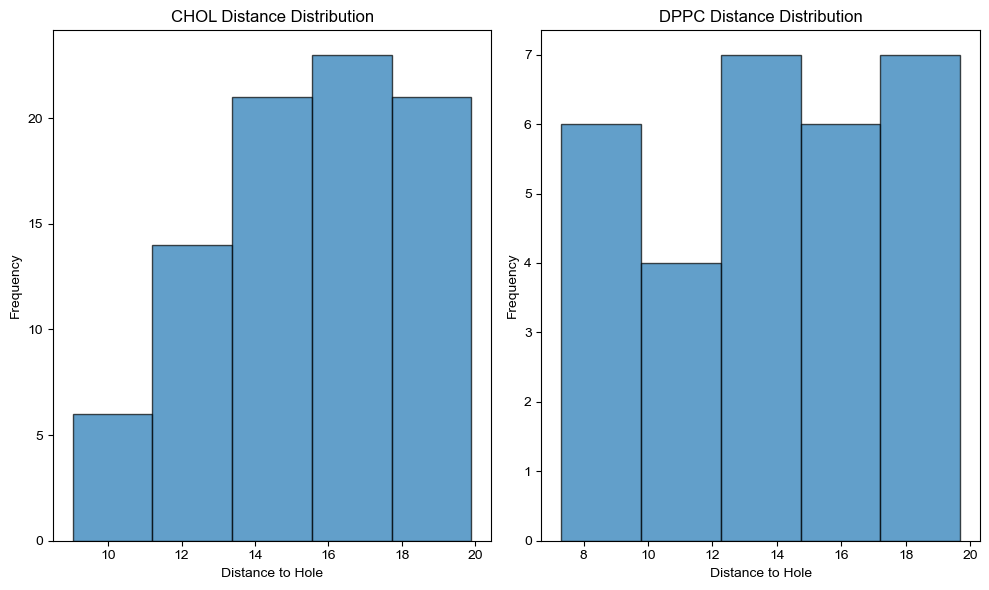


=== Pandas详细分析 ===
数据前几行:
   residue_id residue_name   distance_to_hole                    coordinates
0          75         CHOL 14.283406598626447          [237.0, 256.2, 188.2]
1         162         CHOL 17.557573554950395  [232.70001, 265.30002, 180.7]
2         826         CHOL 16.302192175737215          [251.8, 235.8, 184.3]
3        1224         CHOL  15.58434235727676          [266.9, 231.7, 190.3]
4        1487         CHOL 19.043451791989487      [255.3, 234.9, 198.09999]

描述性统计:
              count               mean               std                min  \
residue_name                                                                  
CHOL           85.0  15.51401889747168 2.788316770064896  9.031440057239358   
DPPC           30.0 13.892786390507256 3.813951758998696 7.3079405147019285   

                            25%                50%               75%  \
residue_name                                                           
CHOL         13.703001824034176 15.7074936

In [82]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

# 假设您的数据存储在这样的列表中
data = nearby_residues

def analyze_lipid_data(data):
    """分析脂质数据"""

    # 1. 统计不同residue_name的数量
    residue_names = [item['residue_name'] for item in data]
    residue_counts = Counter(residue_names)

    print("=== 不同residue_name的数量统计 ===")
    for residue, count in residue_counts.items():
        print(f"{residue}: {count}个")
    print()

    # 2. 统计不同residue_name的distance_to_hole分布
    print("=== 不同residue_name的distance_to_hole分布 ===")
    distance_distributions = {}

    for residue in set(residue_names):
        distances = [item['distance_to_hole'] for item in data if item['residue_name'] == residue]
        distance_distributions[residue] = distances

        print(f"{residue}:")
        print(f"  数量: {len(distances)}")
        print(f"  平均值: {np.mean(distances):.2f}")
        print(f"  标准差: {np.std(distances):.2f}")
        print(f"  最小值: {np.min(distances):.2f}")
        print(f"  最大值: {np.max(distances):.2f}")
        print(f"  具体数值: {[f'{d:.2f}' for d in distances]}")
        print()

    # 3. 输出所有的resid列表
    print("=== 所有的residue_id列表 ===")
    residue_ids = [item['residue_id'] for item in data]
    print(f"residue_id列表: {residue_ids}")

    # 按residue_name分组显示residue_id
    print("\n=== 按residue_name分组的residue_id ===")
    residue_groups = {}
    for item in data:
        name = item['residue_name']
        if name not in residue_groups:
            residue_groups[name] = []
        residue_groups[name].append(item['residue_id'])

    for residue, ids in residue_groups.items():
        print(f"{residue}: {ids}")

    return residue_counts, distance_distributions, residue_ids

# 执行分析
residue_counts, distance_distributions, residue_ids = analyze_lipid_data(data)

# 可选：可视化distance分布
def plot_distance_distributions(distance_distributions):
    """绘制distance分布图"""
    plt.figure(figsize=(10, 6))

    for i, (residue, distances) in enumerate(distance_distributions.items()):
        plt.subplot(1, len(distance_distributions), i+1)
        plt.hist(distances, bins=5, alpha=0.7, edgecolor='black')
        plt.title(f'{residue} Distance Distribution')
        plt.xlabel('Distance to Hole')
        plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# 如果需要绘图，取消下面的注释
plot_distance_distributions(distance_distributions)

# 可选：使用pandas进行更详细的分析
def pandas_analysis(data):
    """使用pandas进行数据分析"""
    df = pd.DataFrame(data)

    print("\n=== Pandas详细分析 ===")
    print("数据前几行:")
    print(df.head())

    print("\n描述性统计:")
    print(df.groupby('residue_name')['distance_to_hole'].describe())

    return df

# 使用pandas分析
df = pandas_analysis(data)

Charts saved as lipid_analysis_charts.png


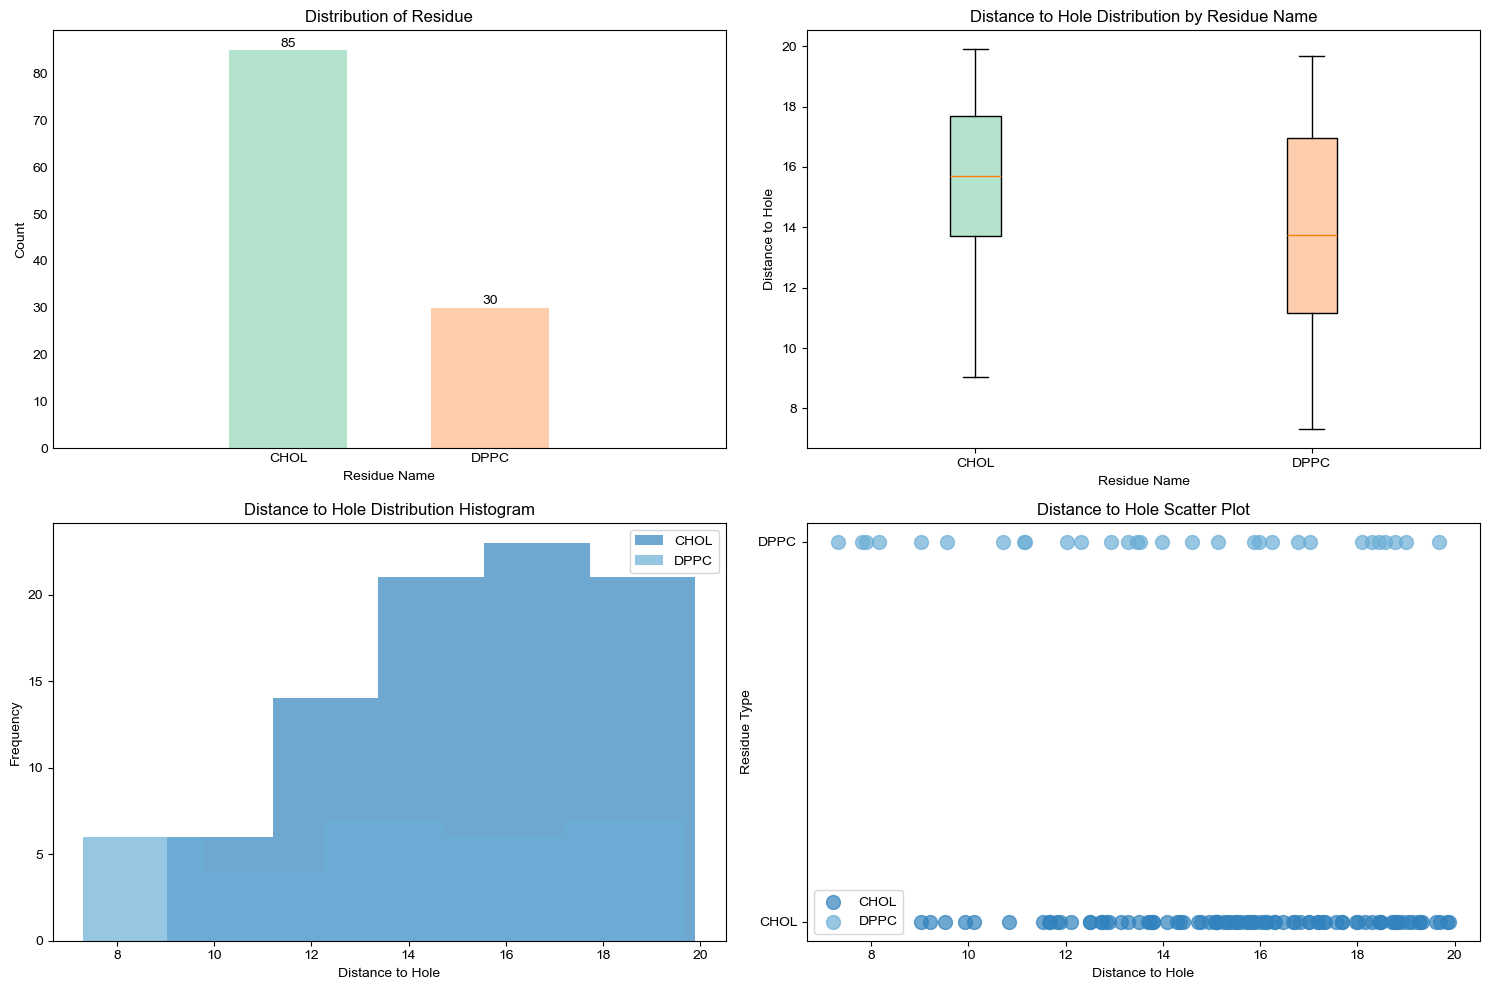

In [119]:
# 设置图表样式
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Liberation Sans']
plt.rcParams['axes.unicode_minus'] = False

# 创建图表
fig = plt.figure(figsize=(15, 10))

# 1. 绘制不同residue_name的数量柱状图
ax1 = fig.add_subplot(2, 2, 1)
residues = list(residue_counts.keys())
counts = list(residue_counts.values())
bars = ax1.bar([0.44,0.56], counts, color=plt.cm.Pastel2([0, 1]) , width=0.07)
ax1.set_title('Distribution of Residue')
ax1.set_xlabel('Residue Name')
ax1.set_ylabel('Count')
ax1.set_xticklabels(residues)
ax1.set_xticks([0.44,0.56])
ax1.set_xlim(0.3,0.7)
ax1.tick_params(length=0)
# 在柱子上显示数值
for bar, count in zip(bars, counts):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, str(count),
             ha='center', va='bottom')

# 2. 绘制不同residue_name的distance_to_hole箱线图
ax2 = fig.add_subplot(2, 2, 2)
distances_list = [distance_distributions[residue] for residue in residues]
box_plot = ax2.boxplot(distances_list, labels=residues, patch_artist=True)
# 设置箱线图颜色
colors = plt.cm.Pastel2([0, 1])
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
ax2.set_title('Distance to Hole Distribution by Residue Name')
ax2.set_xlabel('Residue Name')
ax2.set_ylabel('Distance to Hole')

# 3. 绘制不同residue_name的distance_to_hole直方图
ax3 = fig.add_subplot(2, 2, 3)
for i, (residue, distances) in enumerate(distance_distributions.items()):
    ax3.hist(distances, alpha=0.7, label=residue, bins=5, color=plt.cm.tab20c(i))
ax3.set_title('Distance to Hole Distribution Histogram')
ax3.set_xlabel('Distance to Hole')
ax3.set_ylabel('Frequency')
ax3.legend()

# 4. 绘制散点图显示所有数据点
ax4 = fig.add_subplot(2, 2, 4)
colors_scatter = plt.cm.tab20c(range(len(residues)))
for i, (residue, distances) in enumerate(distance_distributions.items()):
    y_positions = [i] * len(distances)
    ax4.scatter(distances, y_positions, label=residue, s=100, alpha=0.7, color=colors_scatter[i])
ax4.set_title('Distance to Hole Scatter Plot')
ax4.set_xlabel('Distance to Hole')
ax4.set_ylabel('Residue Type')
ax4.set_yticks(range(len(residues)))
ax4.set_yticklabels(residues)
ax4.legend()

plt.tight_layout()
chart_path = 'lipid_analysis_charts.png'
plt.savefig(chart_path, dpi=300, bbox_inches='tight')
print(f"Charts saved as {chart_path}")

In [99]:
import MDAnalysis as mda
from MDAnalysis.coordinates.GRO import GROWriter

def write_residues_gro(u, residue_ids, output_file="selected_residues_300ns.gro"):
    """
    根据residue IDs从300ns的轨迹中输出gro文件

    Parameters:
    u: MDAnalysis Universe对象
    residue_ids: 要选择的residue ID列表
    output_file: 输出文件名
    """

    # 选择指定的residues
    selection = f"resid {' '.join(map(str, residue_ids))}"
    selected_residues = u.select_atoms(selection)

    # 写入gro文件
    selected_residues.write(output_file)

    print(f"Selected {len(selected_residues)} atoms from residues {residue_ids}")
    print(f"GRO file saved as: {output_file}")

# 使用示例
if __name__ == "__main__":
    # 加载轨迹文件（假设有300ns的轨迹）
    u = mda.Universe("300ns.gro")  # 根据实际文件名修改

    # 要输出的residue IDs
    residue_ids_to_output = residue_ids  # 修改为需要的residue IDs

    # 输出gro文件
    write_residues_gro(u, residue_ids_to_output)

Selected 1125 atoms from residues [np.int64(75), np.int64(162), np.int64(826), np.int64(1224), np.int64(1487), np.int64(1609), np.int64(1868), np.int64(1909), np.int64(1954), np.int64(2251), np.int64(2325), np.int64(2372), np.int64(2483), np.int64(2484), np.int64(2733), np.int64(3286), np.int64(3349), np.int64(3352), np.int64(3377), np.int64(3380), np.int64(3383), np.int64(3387), np.int64(3392), np.int64(3405), np.int64(3428), np.int64(3429), np.int64(3438), np.int64(3458), np.int64(3464), np.int64(3471), np.int64(3472), np.int64(3501), np.int64(3517), np.int64(3524), np.int64(3562), np.int64(3584), np.int64(3591), np.int64(3618), np.int64(3665), np.int64(3706), np.int64(3707), np.int64(3709), np.int64(3711), np.int64(3750), np.int64(3878), np.int64(3883), np.int64(3925), np.int64(4222), np.int64(4275), np.int64(4396), np.int64(4559), np.int64(4639), np.int64(4640), np.int64(4815), np.int64(4983), np.int64(5064), np.int64(5108), np.int64(5142), np.int64(5267), np.int64(5268), np.int64(

In [138]:
import numpy as np

def unwrap_lipids_simple(input_gro, output_gro):
    """
    最简版本的脂质双层展开
    """
    # 读取文件
    with open(input_gro, 'r') as f:
        lines = f.readlines()

    title = lines[0].strip()
    num_atoms = int(lines[1].strip())

    coords = []
    atom_info = []

    for i in range(2, 2 + num_atoms):
        line = lines[i]
        res_num = int(line[0:5])
        res_name = line[5:10].strip()
        atom_name = line[10:15].strip()
        x, y, z = float(line[20:28]), float(line[28:36]), float(line[36:44])

        coords.append([x, y, z])
        atom_info.append([res_num, res_name, atom_name])

    coords = np.array(coords)

    # 计算中心和平均半径
    center = np.mean(coords[:, :2], axis=0)
    rel_coords = coords[:, :2] - center
    r = np.sqrt(rel_coords[:, 0]**2 + rel_coords[:, 1]**2)
    theta = np.arctan2(rel_coords[:, 1], rel_coords[:, 0])
    theta[theta < 0] += 2 * np.pi
    avg_radius = np.mean(r)

    # 展开坐标
    unwrapped_coords = np.zeros_like(coords)
    unwrapped_coords[:, 0] = theta * avg_radius  # X: 圆周展开
    unwrapped_coords[:, 1] = r - avg_radius      # Y: 径向偏差
    unwrapped_coords[:, 2] = coords[:, 2]         # Z: 不变

    # 写入文件
    with open(output_gro, 'w') as f:
        f.write(f"{title} - Unwrapped\n")
        f.write(f"{num_atoms:5d}\n")

        for i in range(num_atoms):
            res_num, res_name, atom_name = atom_info[i]
            x, y, z = unwrapped_coords[i]
            f.write(f"{res_num:5d}{res_name:<5s}{atom_name:>5s}{i+1:5d}{x:8.3f}{y:8.3f}{z:8.3f}\n")

        f.write(f"{100.0:10.5f}{100.0:10.5f}{100.0:10.5f}\n")

    print(f"展开完成！输出文件: {output_gro}")
    print(f"平均半径: {avg_radius:.3f} nm, 展开长度: {np.ptp(unwrapped_coords[:, 0]):.2f} nm")

# 使用
unwrap_lipids_simple("z_200.gro", "z_200_unwrapped.gro")

展开完成！输出文件: z_200_unwrapped.gro
平均半径: 5.504 nm, 展开长度: 34.57 nm


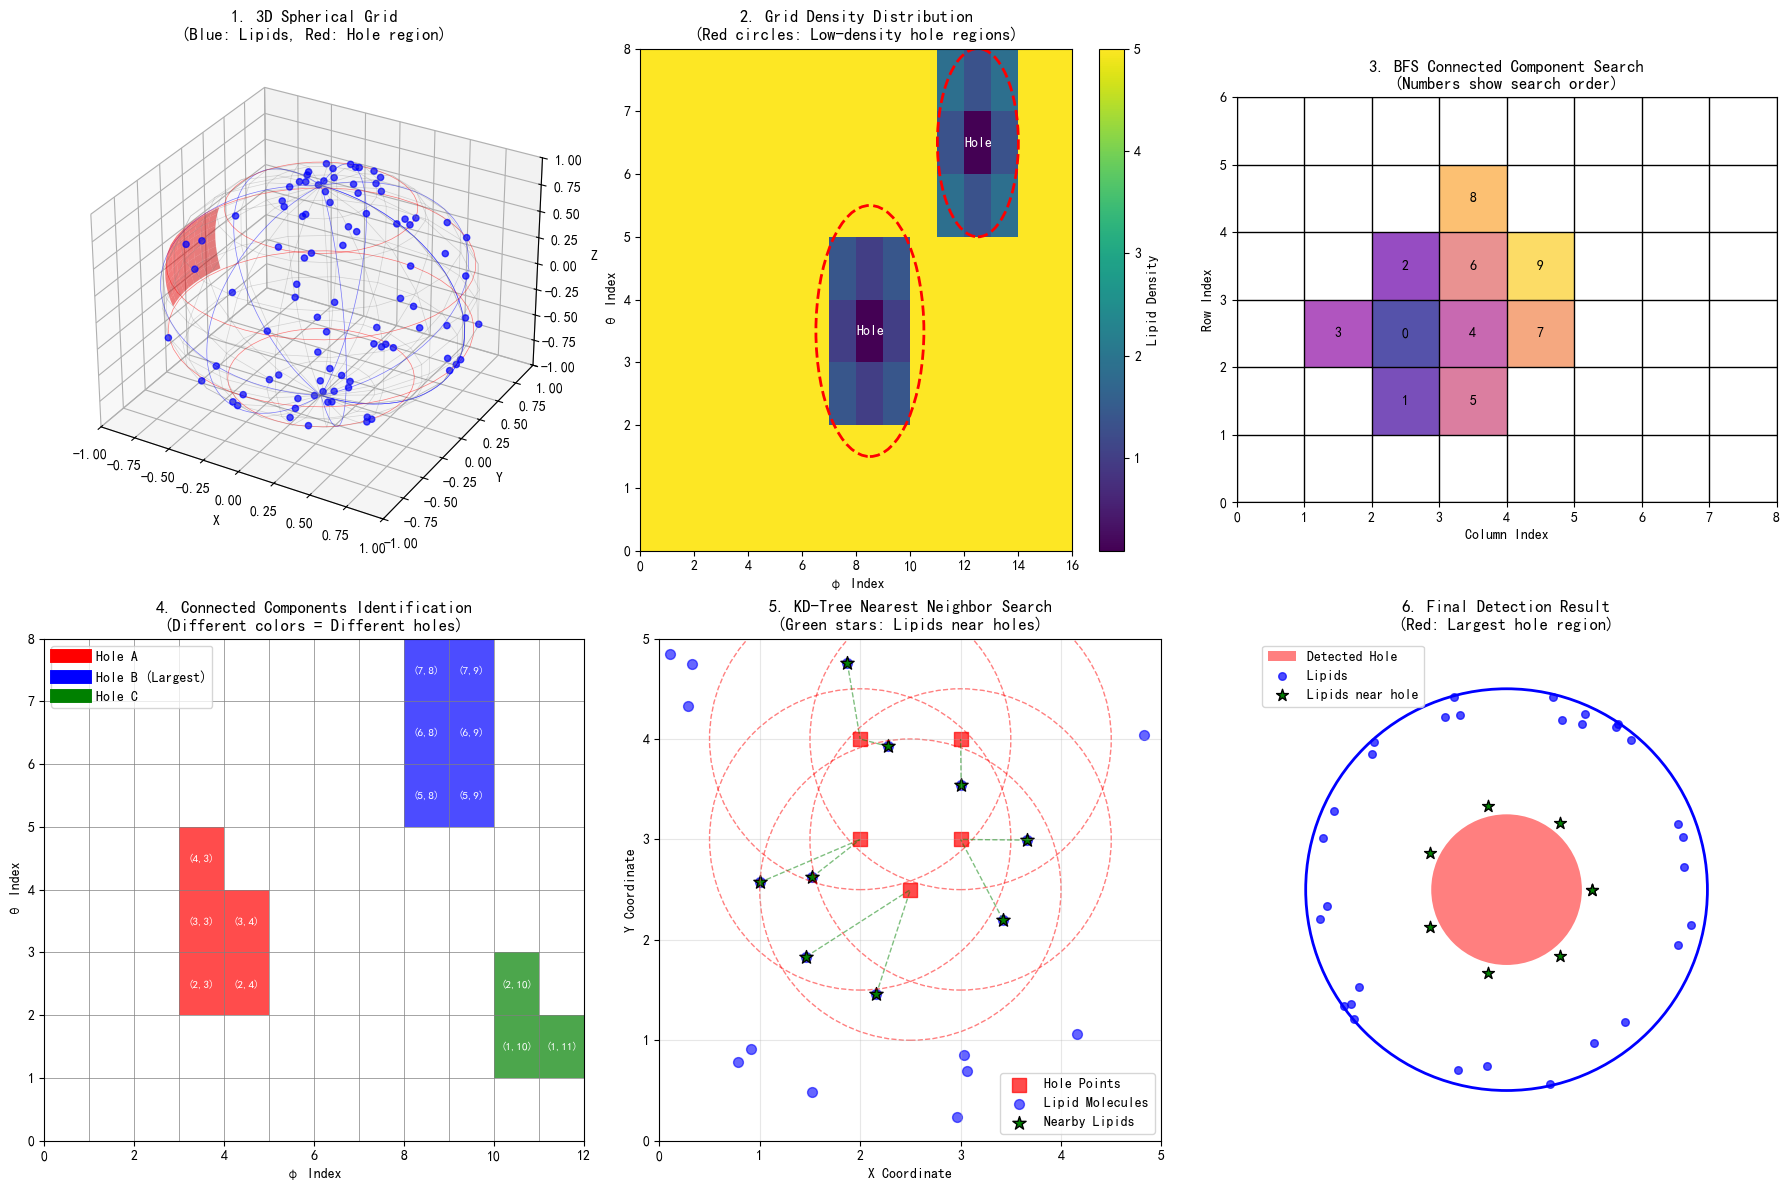

In [142]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from collections import deque
from mpl_toolkits.mplot3d import Axes3D

def create_simple_diagrams_english():
    """Create simplified core algorithm diagrams in English"""
    fig = plt.figure(figsize=(18, 12))

    # Create subplot grid
    ax1 = fig.add_subplot(2, 3, 1, projection='3d')  # 3D plot for first diagram
    ax2 = fig.add_subplot(2, 3, 2)
    ax3 = fig.add_subplot(2, 3, 3)  # Now BFS Search
    ax4 = fig.add_subplot(2, 3, 4)  # Now Connected Components
    ax5 = fig.add_subplot(2, 3, 5)
    ax6 = fig.add_subplot(2, 3, 6)

    axes = [[ax1, ax2, ax3], [ax4, ax5, ax6]]

    # 1. 3D Spherical Grid Diagram
    create_3d_grid_diagram(axes[0][0])

    # 2. Density Distribution Diagram
    create_density_diagram_english(axes[0][1])

    # 3. BFS Search Diagram (swapped with Connected Components)
    create_bfs_diagram_english(axes[0][2])

    # 4. Connected Components Diagram (swapped with BFS)
    create_connected_components_diagram_english(axes[1][0])

    # 5. KD-Tree Nearest Neighbor Diagram
    create_kdtree_diagram_english(axes[1][1])

    # 6. Final Result Diagram
    create_final_result_diagram_english(axes[1][2])

    plt.tight_layout()
    plt.savefig('simple_hole_detection_english.png', dpi=300, bbox_inches='tight')
    plt.show()

def create_3d_grid_diagram(ax):
    """3D Spherical Grid Diagram"""
    # Create spherical surface
    u = np.linspace(0, 2 * np.pi, 20)
    v = np.linspace(0, np.pi, 10)

    # Create meshgrid for the sphere
    u_grid, v_grid = np.meshgrid(u, v)

    # Convert to Cartesian coordinates
    x = np.sin(v_grid) * np.cos(u_grid)
    y = np.sin(v_grid) * np.sin(u_grid)
    z = np.cos(v_grid)

    # Plot the wireframe sphere
    ax.plot_wireframe(x, y, z, color='gray', alpha=0.3, linewidth=0.5)

    # Add grid lines to show spherical coordinates
    # Longitude lines (phi)
    for phi in np.linspace(0, 2*np.pi, 8):
        theta_line = np.linspace(0, np.pi, 50)
        x_line = np.sin(theta_line) * np.cos(phi)
        y_line = np.sin(theta_line) * np.sin(phi)
        z_line = np.cos(theta_line)
        ax.plot(x_line, y_line, z_line, 'b-', alpha=0.5, linewidth=0.5)

    # Latitude lines (theta)
    for theta in np.linspace(0, np.pi, 6):
        phi_line = np.linspace(0, 2*np.pi, 50)
        x_line = np.sin(theta) * np.cos(phi_line)
        y_line = np.sin(theta) * np.sin(phi_line)
        z_line = np.cos(theta) * np.ones_like(phi_line)
        ax.plot(x_line, y_line, z_line, 'r-', alpha=0.5, linewidth=0.5)

    # Add lipid points on the surface
    np.random.seed(42)
    n_lipids = 100
    theta_points = np.random.uniform(0, np.pi, n_lipids)
    phi_points = np.random.uniform(0, 2*np.pi, n_lipids)

    x_points = np.sin(theta_points) * np.cos(phi_points)
    y_points = np.sin(theta_points) * np.sin(phi_points)
    z_points = np.cos(theta_points)

    # Create a hole region (no lipids)
    hole_center_theta, hole_center_phi = np.pi/2, np.pi
    hole_radius = 0.8

    # Calculate distance from hole center
    distances = np.sqrt((theta_points - hole_center_theta)**2 +
                       (phi_points - hole_center_phi)**2)

    # Remove points in the hole region
    mask = distances > hole_radius
    x_plot = x_points[mask]
    y_plot = y_points[mask]
    z_plot = z_points[mask]

    ax.scatter(x_plot, y_plot, z_plot, s=20, c='blue', alpha=0.7, label='Lipid molecules')

    # Mark the hole region
    hole_theta = np.linspace(hole_center_theta - 0.3, hole_center_theta + 0.3, 10)
    hole_phi = np.linspace(hole_center_phi - 0.3, hole_center_phi + 0.3, 10)
    hole_theta, hole_phi = np.meshgrid(hole_theta, hole_phi)

    hole_x = np.sin(hole_theta) * np.cos(hole_phi)
    hole_y = np.sin(hole_theta) * np.sin(hole_phi)
    hole_z = np.cos(hole_theta)

    ax.plot_surface(hole_x, hole_y, hole_z, color='red', alpha=0.5, label='Hole region')

    # Add labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('1. 3D Spherical Grid\n(Blue: Lipids, Red: Hole region)', fontweight='bold')

    # Set equal aspect ratio
    max_range = 1.0
    ax.set_xlim([-max_range, max_range])
    ax.set_ylim([-max_range, max_range])
    ax.set_zlim([-max_range, max_range])

def create_density_diagram_english(ax):
    """Density Distribution Diagram"""
    # Create simulated density matrix
    density = np.ones((8, 16)) * 5  # Base density

    # Add hole regions (low density)
    hole_centers = [(3, 8), (6, 12)]
    hole_radii = [2, 1.5]

    for (center_i, center_j), radius in zip(hole_centers, hole_radii):
        for i in range(density.shape[0]):
            for j in range(density.shape[1]):
                dist = np.sqrt((i - center_i)**2 + (j - center_j)**2)
                if dist < radius:
                    density[i, j] = max(0.1, dist/radius * 2)  # Reduce density in holes

    # Plot heatmap
    im = ax.imshow(density, cmap='viridis', aspect='auto', origin='lower',
                  extent=[0, 16, 0, 8])

    # Mark hole regions
    for (center_i, center_j), radius in zip(hole_centers, hole_radii):
        circle = plt.Circle((center_j + 0.5, center_i + 0.5), radius,
                           fill=False, color='red', linewidth=2, linestyle='--')
        ax.add_patch(circle)
        ax.text(center_j + 0.5, center_i + 0.5, 'Hole',
               ha='center', va='center', color='white', fontweight='bold')

    ax.set_xlabel('φ Index')
    ax.set_ylabel('θ Index')
    ax.set_title('2. Grid Density Distribution\n(Red circles: Low-density hole regions)', fontweight='bold')
    plt.colorbar(im, ax=ax, label='Lipid Density')

def create_bfs_diagram_english(ax):
    """BFS Search Diagram (Now Figure 3)"""
    # Create grid
    grid = np.zeros((6, 8))

    # Define a hole region
    hole_cells = [(1, 2), (1, 3), (2, 1), (2, 2), (2, 3), (2, 4),
                  (3, 2), (3, 3), (3, 4), (4, 3)]

    # Mark hole cells
    for i, j in hole_cells:
        if 0 <= i < grid.shape[0] and 0 <= j < grid.shape[1]:
            grid[i, j] = 1

    # Draw grid lines
    for i in range(grid.shape[0] + 1):
        ax.axhline(i, color='black', linewidth=1)
    for j in range(grid.shape[1] + 1):
        ax.axvline(j, color='black', linewidth=1)

    # Mark BFS search order
    start = (2, 2)  # Starting point
    visited_order = []

    # Simple BFS simulation
    queue = deque([start])
    visited = set([start])
    order = 0

    while queue:
        current = queue.popleft()
        i, j = current
        visited_order.append((current, order))
        order += 1

        # 4-neighborhood
        neighbors = [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]
        for ni, nj in neighbors:
            if (0 <= ni < grid.shape[0] and 0 <= nj < grid.shape[1] and
                grid[ni, nj] == 1 and (ni, nj) not in visited):
                visited.add((ni, nj))
                queue.append((ni, nj))

    # Draw search order
    for (i, j), step in visited_order:
        color = plt.cm.plasma(step / len(visited_order))
        rect = patches.Rectangle((j, i), 1, 1, facecolor=color, alpha=0.7)
        ax.add_patch(rect)
        ax.text(j + 0.5, i + 0.5, str(step),
               ha='center', va='center', fontweight='bold')

    ax.set_xlim(0, grid.shape[1])
    ax.set_ylim(0, grid.shape[0])
    ax.set_xlabel('Column Index')
    ax.set_ylabel('Row Index')
    ax.set_title('3. BFS Connected Component Search\n(Numbers show search order)', fontweight='bold')
    ax.set_aspect('equal')

def create_connected_components_diagram_english(ax):
    """Connected Components Diagram (Now Figure 4)"""
    # Create binary hole mask
    hole_mask = np.zeros((8, 12), dtype=bool)

    # Define hole regions
    holes = [
        [(2, 3), (2, 4), (3, 3), (3, 4), (4, 3)],  # Hole 1
        [(5, 8), (5, 9), (6, 8), (6, 9), (7, 8), (7, 9)],  # Hole 2 (largest)
        [(1, 10), (1, 11), (2, 10)]               # Hole 3
    ]

    # Fill hole regions
    colors = ['red', 'blue', 'green']
    labels = ['Hole A', 'Hole B (Largest)', 'Hole C']

    for i, hole in enumerate(holes):
        for (ti, pi) in hole:
            if 0 <= ti < hole_mask.shape[0] and 0 <= pi < hole_mask.shape[1]:
                hole_mask[ti, pi] = True
                # Draw colored cells
                rect = patches.Rectangle((pi, ti), 1, 1,
                                       facecolor=colors[i], alpha=0.7)
                ax.add_patch(rect)
                ax.text(pi + 0.5, ti + 0.5, f'({ti},{pi})',
                       ha='center', va='center', fontsize=8, color='white')

    # Draw grid lines
    for i in range(hole_mask.shape[0] + 1):
        ax.axhline(i, color='gray', linewidth=0.5)
    for j in range(hole_mask.shape[1] + 1):
        ax.axvline(j, color='gray', linewidth=0.5)

    ax.set_xlim(0, hole_mask.shape[1])
    ax.set_ylim(0, hole_mask.shape[0])
    ax.set_xlabel('φ Index')
    ax.set_ylabel('θ Index')
    ax.set_title('4. Connected Components Identification\n(Different colors = Different holes)', fontweight='bold')

    # Add legend
    for i, (color, label) in enumerate(zip(colors, labels)):
        ax.plot([], [], color=color, label=label, linewidth=10)
    ax.legend()

def create_kdtree_diagram_english(ax):
    """KD-Tree Nearest Neighbor Diagram"""
    np.random.seed(42)

    # Create hole representative points (red)
    hole_points = np.array([[2, 3], [3, 3], [2, 4], [3, 4], [2.5, 2.5]])

    # Create lipid points (blue)
    lipid_points = np.random.uniform(0, 5, (20, 2))

    # Plot all points
    ax.scatter(hole_points[:, 0], hole_points[:, 1], s=100, c='red',
              marker='s', label='Hole Points', alpha=0.7)
    ax.scatter(lipid_points[:, 0], lipid_points[:, 1], s=50, c='blue',
              marker='o', label='Lipid Molecules', alpha=0.6)

    # Nearest neighbor search: find lipids within distance < 1.5 from holes
    from scipy.spatial import distance_matrix
    dist_matrix = distance_matrix(lipid_points, hole_points)
    min_distances = np.min(dist_matrix, axis=1)

    nearby_mask = min_distances < 1.5
    nearby_lipids = lipid_points[nearby_mask]

    # Mark nearby lipids
    ax.scatter(nearby_lipids[:, 0], nearby_lipids[:, 1], s=100, c='green',
              marker='*', label='Nearby Lipids', edgecolors='black', linewidth=1)

    # Draw distance circles
    for hole_point in hole_points:
        circle = plt.Circle(hole_point, 1.5, fill=False, color='red',
                           linestyle='--', linewidth=1, alpha=0.5)
        ax.add_patch(circle)

    # Draw connection lines (nearby lipids to closest hole point)
    for lipid in nearby_lipids:
        closest_hole = hole_points[np.argmin(distance_matrix([lipid], hole_points))]
        ax.plot([lipid[0], closest_hole[0]], [lipid[1], closest_hole[1]],
               'g--', alpha=0.5, linewidth=1)

    ax.set_xlim(0, 5)
    ax.set_ylim(0, 5)
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_title('5. KD-Tree Nearest Neighbor Search\n(Green stars: Lipids near holes)', fontweight='bold')
    ax.legend()
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)

def create_final_result_diagram_english(ax):
    """Final Result Diagram"""
    # Create simplified liposome representation
    circle = plt.Circle((0.5, 0.5), 0.4, fill=False, color='blue', linewidth=2)
    ax.add_patch(circle)

    # Add hole region
    hole_center = (0.5, 0.5)
    hole_radius = 0.15
    hole = patches.Wedge(hole_center, hole_radius, 0, 360,
                        facecolor='red', alpha=0.5, label='Detected Hole')
    ax.add_patch(hole)

    # Add lipid points
    np.random.seed(42)
    n_lipids = 30
    angles = np.random.uniform(0, 2*np.pi, n_lipids)
    distances = np.random.uniform(0.35, 0.4, n_lipids)

    x = 0.5 + distances * np.cos(angles)
    y = 0.5 + distances * np.sin(angles)

    # Don't place lipids in the hole region
    mask = np.sqrt((x - 0.5)**2 + (y - 0.5)**2) > hole_radius + 0.05
    ax.scatter(x[mask], y[mask], s=30, c='blue', alpha=0.7, label='Lipids')

    # Add nearby lipids (hole edge)
    edge_angles = np.linspace(0, 2*np.pi, 8)
    edge_x = 0.5 + (hole_radius + 0.02) * np.cos(edge_angles)
    edge_y = 0.5 + (hole_radius + 0.02) * np.sin(edge_angles)
    ax.scatter(edge_x, edge_y, s=80, c='green', marker='*',
              label='Lipids near hole', edgecolors='black')

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title('6. Final Detection Result\n(Red: Largest hole region)', fontweight='bold')
    ax.legend(loc='upper left', bbox_to_anchor=(0, 1))

# Run the English diagram generation
if __name__ == "__main__":
    create_simple_diagrams_english()